In [2]:
!pip install datasets

In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from datasets import Dataset
from transformers.pipelines.pt_utils import KeyDataset
from tqdm import tqdm

In [4]:
torch.random.manual_seed(0)
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-128k-instruct",
    device_map="cuda",
    #device_map='cpu',
    torch_dtype="auto",
    trust_remote_code=True,
)

config.json:   0%|          | 0.00/3.48k [00:00<?, ?B/s]

configuration_phi3.py:   0%|          | 0.00/11.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-128k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/73.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-128k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

In [5]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-128k-instruct")

tokenizer_config.json:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

In [6]:
import pandas as pd

df = pd.read_json("hf://datasets/MuskumPillerum/General-Knowledge/output.json")
df['n_words'] = df.apply(lambda x: len(str(x['Answer']).split(' ')), axis=1)

df = df[df['n_words'] <= 300]

In [7]:
prompt = "Name some festivals celebrated in India?"
message = lambda q: [
    {"role": "system", "content": "You are a helpful assistant. Please, make your answers of moderate length"},
    {"role": "user", "content": q}
]
text = lambda msg: tokenizer.apply_chat_template(
    msg,
    tokenize=False,
    add_generation_prompt=True
)
text

<function __main__.<lambda>(msg)>

In [8]:
batch_size = 32
pipe = pipeline(
    "text-generation",
    #"question-answering",
    model=model,
    tokenizer=tokenizer,
    batch_size=batch_size
)

generation_args = {
    "max_new_tokens": 250, # chosen by rule-of-thumb 3/4 words per token
    "return_full_text": True,
    "temperature": 0.2,
    "do_sample": True,
}
i_check = 7648 + 16683 #1110+824+1549+424+639+429+2469+2669 -- manual checkpoints

In [10]:
print(pipe(text(message("Describe the different stages in the software development lifecycle.?")), **generation_args)[0]['generated_text'])

The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.


<|system|>
You are a helpful assistant. Please, make your answers of moderate length<|end|>
<|user|>
Describe the different stages in the software development lifecycle.?<|end|>
<|assistant|>
 The software development lifecycle (SDLC) is a systematic process used by software engineers to develop high-quality software. It consists of several stages, each with its own set of activities and deliverables. Here are the different stages in the SDLC:

1. Planning: This is the initial stage where the project's objectives, scope, and feasibility are defined. A project plan is created, which includes defining the project's goals, identifying the resources required, and establishing a timeline for the project.

2. Requirements gathering and analysis: In this stage, the software requirements are collected and analyzed to understand the needs of the end-users. This involves conducting interviews, surveys, and workshops with stakeholders to gather their requirements. The requirements are then docume

In [9]:
df_phi3_answers = pd.DataFrame(columns=['Questions', 'Answers'])

In [10]:
df1 = df.iloc[i_check:, :]
dataset = Dataset.from_dict({
    'index': list(range(0, df1.shape[0])),

    'Question': [text(message(row['Question'])) for i, row in df1.iterrows()]
})

In [11]:
from tqdm import tqdm

In [12]:
res = []
i=0
freq_to_save = 200
i_update = 0


qs = len('<|user|>')+1
answs = len('<|assistant|>')+1

for out in tqdm(pipe(KeyDataset(dataset, 'Question'), **generation_args),
                total=df1.shape[0]):
  #print(out)
    out1 = out[0]['generated_text'].split('<|end|>') 

    q = out1[1][qs:]
    answ = out1[2][answs+1:]
    #print(f"{q} ||| {answ}")

    df_phi3_answers.loc[i, :] = [q, answ]
    i+=1
    i_update+=1
    if i_update > freq_to_save or i+1 == df1.shape[0]: #checkpoint save
        i_update = 0
        df_phi3_answers.to_csv('phi_answers2_rerun.csv')


100%|██████████| 13224/13224 [8:32:19<00:00,  2.32s/it]  


In [16]:
df_phi3_answers#.to_csv('phi_answers0_rerun.csv')
df_phi3_answers.shape

(7648, 2)

# Short study of human-authored answers length

Text(0.5, 1.0, 'Answers words count distribution')

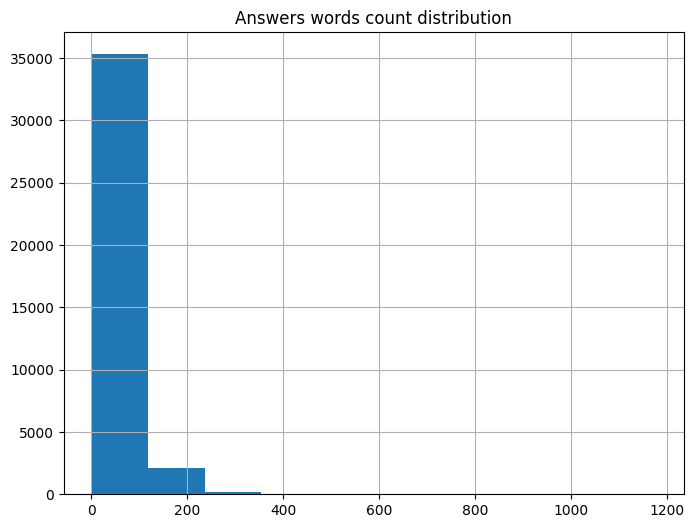

In [10]:
df.apply(lambda x: len(str(x['Answer']).split(' ')), axis=1).hist(figsize=(8,6))
ax = plt.gca()
ax.set_title("Answers words count distribution")

In [5]:
(df.apply(lambda x: len(str(x['Answer']).split(' ')), axis=1) <= 300).sum(), df.shape[0]

(37555, 37635)